In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 9.4 MB/s eta 0:00:00


### 0. 라이브러리

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [133]:
# 라이브러리
import warnings
warnings.filterwarnings('ignore')

import os
import time
import pickle
import random
import zipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy
from torchsummary import summary

from torchvision import transforms

import transformers
from transformers import AutoTokenizer, AutoModel, ViTFeatureExtractor, ViTModel

from peft import get_peft_model, LoraConfig, TaskType

In [5]:
# OS 충돌 방지
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Matplotlib 커널 종료 방지
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [6]:
# 시드 고정
def fixSEED(seed, deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 42
fixSEED(seed=seed)

In [11]:
# 디렉토리 설정
dir = 'MultiModal'
path = '/content/drive/MyDrive/Projects/Model/' + dir
os.chdir(path)
print('Current path {}'.format(os.getcwd()))

Current path /content/drive/MyDrive/Projects/Model/MultiModal


In [8]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 1. 썸네일 데이터 압축 해제

In [13]:
def unzip_file(zip_file_path, extract_to_path):
    # 압축 해제할 디렉토리가 존재하지 않으면 생성
    if not os.path.exists(extract_to_path):
        os.makedirs(extract_to_path)

    # zipfile 모듈을 사용하여 압축 해제
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)

    print(f"'{zip_file_path}' has been successfully extracted to '{extract_to_path}'")

In [14]:
# 압축 해제할 경로 설정
zip_file_path = 'ThumbnailsData/Thumbnails.zip'
extract_to_path = 'ThumbnailsData'

# 함수적용
unzip_file(zip_file_path, extract_to_path)

'ThumbnailsData/Thumbnails.zip' has been successfully extracted to 'ThumbnailsData'


### 2. 텍스트 데이터 가져오기

In [19]:
# 데이터 불러오기
with open('YouTube_Total.pkl', 'rb') as f:
    data = pickle.load(f)

In [22]:
# 자동생성자막 없는 경우 제거
new_data = data[~data['content'].str.startswith('⚠')]

In [23]:
# 유튜버 '퍼플티비' 제거 (진짜 뉴스임 + 자동생성자막이 대부분 없음)
new_data = new_data[new_data['youtuber'] != '퍼플티비']

In [25]:
# 제거 전후 차이 확인
print('제거 이전 : {}'.format(len(data)))
print('제거 이후 : {}'.format(len(new_data)))
print('-'*20)
print('제거된 영상 개수 : {}'.format(len(data) - len(new_data)))

제거 이전 : 4816
제거 이후 : 4157
--------------------
제거된 영상 개수 : 659


### 3. 썸네일이 없는 경우 확인

In [26]:
# 썸네일 이미지가 있는 데이터인지 확인하는 열
new_data['have_thumbnail'] = 0

In [27]:
# 썸네일 파일 경로
thumbnail_path = 'ThumbnailsData/Thumbnails'

# 각 video_id에 대해 파일 존재 여부 확인
for i in tqdm(new_data.index, desc="Checking thumbnails"):
    video_id = new_data.at[i, 'video_id']
    file_path = os.path.join(thumbnail_path, f"{video_id}.jpg")
    if os.path.isfile(file_path):
        new_data.at[i, 'have_thumbnail'] = 1

Checking thumbnails: 100%|██████████| 4157/4157 [00:00<00:00, 6127.18it/s]


In [28]:
# 확인
new_data['have_thumbnail'].value_counts()

have_thumbnail
1    4155
0       2
Name: count, dtype: int64

In [30]:
# 썸네일 없는 경우 제거
new_data = new_data[new_data['have_thumbnail'] == 1]

In [31]:
# 최종 확인
new_data['have_thumbnail'].value_counts()

have_thumbnail
1    4155
Name: count, dtype: int64

In [32]:
# 레이블 개수 확인
new_data['label'].value_counts()

label
0    2652
1    1503
Name: count, dtype: int64

### 4. Train/Valid/Test 분리

In [44]:
# Split into Train/Valid/Test
def splitData(data, SEED=42):
    train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)
    train_data, valid_data = train_test_split(train_val_data, test_size=0.25, random_state=SEED)

    print('학습용 데이터 개수 : {}개 \n검증용 데이터 개수 : {}개 \n평가용 데이터 개수 : {}개'.format(len(train_data), len(valid_data), len(test_data)))
    del train_val_data
    return train_data, valid_data, test_data

In [57]:
train_data, valid_data, test_data = splitData(new_data)

학습용 데이터 개수 : 2493개 
검증용 데이터 개수 : 831개 
평가용 데이터 개수 : 831개


### 5. Datasets 및 Dataloader 정의

In [74]:
# 파라미터 개수 확인
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"Trainable Params: {trainable_params} \nAll params: {all_param}")
    print('-'*50)
    print(f"Trainable(%): {round(100 * trainable_params / all_param, 5)}")

In [75]:
# Multi-modal Dataset
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, text_tokenizer, max_length, feature_extractor, image_path):
        self.data = dataframe
        self.text_tokenizer = text_tokenizer
        self.max_length = max_length
        self.feature_extractor = feature_extractor
        self.image_path = image_path

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text'] # 제목 + 자막
        video_id = self.data.iloc[idx]['video_id'] # 영상 ID
        label = self.data.iloc[idx]['label']

        # text 토크나이저
        text_inputs = self.text_tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=self.max_length)
        input_ids = text_inputs['input_ids'].squeeze(0)
        attention_mask = text_inputs['attention_mask'].squeeze(0)

        # 이미지 불러오기
        img_path = os.path.join(self.image_path, f"{video_id}.jpg")
        image = Image.open(img_path).convert('RGB')

        # 이미지 전처리
        image_inputs = self.feature_extractor(images=image, return_tensors='pt')
        pixel_values = image_inputs['pixel_values'].squeeze(0)

        return input_ids, attention_mask, pixel_values, torch.tensor(label, dtype=torch.long)  # 정수형

### 6. 모델 정의

In [160]:
class MultiModalBERT(nn.Module):
    def __init__(self, text_checkpoint, vision_checkpoint, lora_r=2, lora_alpha=1, lora_dropout=0.1):
        super(MultiModalBERT, self).__init__()

        # Pre-trained model for text
        self.text_model = AutoModel.from_pretrained(text_checkpoint, output_hidden_states=True) # 모델은 Model을 사용
        self.img_model = ViTModel.from_pretrained(vision_checkpoint) # 모델은 Model을 사용

        # LoRA Config for text model
        text_config = LoraConfig(
            target_modules=["query", "value"],  # Apply LoRA to the attention layers
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout
        )

        # LoRA Config for image model
        img_config = LoraConfig(
            target_modules=["query", "key"],  # Apply LoRA to the attention layers
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
        )

        # Apply LoRA to each models
        self.text_model = get_peft_model(self.text_model, text_config)
        self.img_model = get_peft_model(self.img_model, img_config)

        # Transformer Encoder for cancat outputs
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.text_model.config.hidden_size + self.img_model.config.hidden_size,
            nhead=8
        )
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)

        # Classifier layer
        self.classifier = nn.Linear(self.text_model.config.hidden_size + self.img_model.config.hidden_size, 2)

        # Dropout
        #self.drop = nn.Dropout(p=0.1)

    def forward(self, input_ids, attention_mask, pixel_values):
        # Text model 전달
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_hidden_state = text_outputs.hidden_states[-1][:, 0, :]  # CLS token

        # Image model 전달
        img_outputs = self.img_model(pixel_values=pixel_values)
        img_hidden_state = img_outputs.last_hidden_state[:, 0, :]  # CLS token

        # image, text 모델의 결과 concat
        concat_hidden_state = torch.cat((text_hidden_state, img_hidden_state), dim=1).unsqueeze(1)

        # concat 결과를 encoder에 전달
        encoded_output = self.transformer_encoder(concat_hidden_state)
        encoded_output = encoded_output[:, 0, :]  # CLS token

        # encoder에 결과를 classifier로 전달
        logits = self.classifier(encoded_output)

        return logits

모델 정의 참고

1. ```VitFeatureExtractor``` : https://velog.io/@heomollang/Pytorch-%ED%97%88%EA%B9%85%ED%8E%98%EC%9D%B4%EC%8A%A4-Feature-Extractor
2. Apply LoRA to ViT : https://huggingface.co/docs/peft/main/en/task_guides/image_classification_lora
3. ```ViTImageProcessor``` : https://huggingface.co/blog/fine-tune-vit
4. LoRA Config ```TaskType``` : https://discuss.huggingface.co/t/task-type-parameter-of-loraconfig/52879/4

### 7. 학습용 Trainer 정의

In [161]:
class Trainer:
    def __init__(self, model, train_dataloader, valid_dataloader, criterion, optimizer, acc_metric, f1_metric, device, num_epochs, wait_for_es):
        self.model = model  # model for training
        self.train_dataloader = train_dataloader  # training dataloader
        self.valid_dataloader = valid_dataloader  # validation dataloader
        self.criterion = criterion  # loss function
        self.optimizer = optimizer  # optimizer
        self.acc_metric = acc_metric  # accuracy metric
        self.f1_metric = f1_metric  # f1 score metric
        self.device = device  # device(cuda or cpu)
        self.num_epochs = num_epochs  # number of epochs
        self.wait_for_es = wait_for_es  # early stopping patience

    def train(self):
        train_loss_history, train_acc_history, train_f1_history = [], [], []
        valid_loss_history, valid_acc_history, valid_f1_history = [], [], []

        best_loss = float('inf')
        count = 0
        best_acc = 0
        start_time = time.time()

        for epoch in range(self.num_epochs):
            print('-' * 80)
            print(f'Epoch {epoch+1}/{self.num_epochs}')
            print('-' * 80)

            train_loss, train_acc, train_f1 = self._train_model()
            valid_loss, valid_acc, valid_f1 = self._valid_model()

            train_loss_history.append(train_loss)
            train_acc_history.append(train_acc)
            train_f1_history.append(train_f1)

            valid_loss_history.append(valid_loss)
            valid_acc_history.append(valid_acc)
            valid_f1_history.append(valid_f1)

            elapsed_time = time.time() - start_time
            print(f'[Train] \t Loss: {train_loss:.4f} \t Acc: {train_acc:.4f} \t F1: {train_f1:.4f}')
            print(f'[Valid] \t Loss: {valid_loss:.4f} \t Acc: {valid_acc:.4f} \t F1: {valid_f1:.4f}')
            print(f'(Epoch {epoch+1} complete in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s)')

            if valid_acc > best_acc:
                best_acc = valid_acc
                try:
                    torch.save(self.model.state_dict(), f'./models/Youtube/RoBERTaWithYouTube(Total)_ACC_{valid_acc:.4f}.pth')
                except:
                    print('Model Not Saved')
                    continue

            if valid_loss < best_loss:
                best_loss = valid_loss
                count = 0
            else:
                count += 1
                if count >= self.wait_for_es:
                    print(f'Early Stopping at Epoch {epoch+1}')
                    break

        return train_loss_history, train_acc_history, train_f1_history, valid_loss_history, valid_acc_history, valid_f1_history

    # Training function
    def _train_model(self):
        self.model.train()

        train_loss = 0
        train_acc = 0
        train_f1 = 0

        for batch in tqdm(self.train_dataloader, desc='Training'):
            input_ids, attention_mask, pixel_values, y = batch
            input_ids, attention_mask, pixel_values, y = input_ids.to(self.device), attention_mask.to(self.device), pixel_values.to(self.device), y.to(self.device)

            outputs = self.model(input_ids, attention_mask, pixel_values)
            loss = self.criterion(outputs, y) # 데이터셋에서 레이블을 long으로 정의함

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            train_loss += loss.item()
            train_acc += self.acc_metric(preds, y).item()
            train_f1 += self.f1_metric(preds, y).item()

        return train_loss / len(self.train_dataloader), train_acc / len(self.train_dataloader), train_f1 / len(self.train_dataloader)

    # Validating function
    def _valid_model(self):
        self.model.eval()

        valid_loss = 0
        valid_acc = 0
        valid_f1 = 0

        with torch.no_grad():
            for batch in tqdm(self.valid_dataloader, desc='Validating'):
                input_ids, attention_mask, pixel_values, y = batch
                input_ids, attention_mask, pixel_values, y = input_ids.to(self.device), attention_mask.to(self.device), pixel_values.to(self.device), y.to(self.device)

                outputs = self.model(input_ids, attention_mask, pixel_values)
                loss = self.criterion(outputs, y)

                preds = torch.argmax(outputs, dim=1)
                valid_loss += loss.item()
                valid_acc += self.acc_metric(preds, y).item()
                valid_f1 += self.f1_metric(preds, y).item()

        return valid_loss / len(self.valid_dataloader), valid_acc / len(self.valid_dataloader), valid_f1 / len(self.valid_dataloader)


### 8. 학습 설정

In [182]:
# 데이터셋 파라미터
batch_size = 16
num_labels = 2
max_length = 64

# text 토크나이저 정의
text_checkpoint = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(text_checkpoint)

# image 프로세서 정의
vision_checkpoint = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(vision_checkpoint)

# image 경로
image_path = 'ThumbnailsData/Thumbnails'

In [183]:
# 데이터셋 정의
train_dataset = MultiModalDataset(train_data, tokenizer, max_length, feature_extractor, image_path)
valid_dataset = MultiModalDataset(valid_data, tokenizer, max_length, feature_extractor, image_path)
test_dataset = MultiModalDataset(test_data, tokenizer, max_length, feature_extractor, image_path)

In [184]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

next(iter(train_dataloader))

[tensor([[    0,     6,  3698,  ...,  5071,  2371,     2],
         [    0,  3629,  2069,  ...,  2031,  2079,     2],
         [    0,    12,  3966,  ...,    80,  8276,     2],
         ...,
         [    0, 27891,  9263,  ...,  8444,  2051,     2],
         [    0,   116,  3667,  ...,  3875,   904,     2],
         [    0, 21832,  5129,  ..., 10283,  1545,     2]]),
 tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 tensor([[[[-0.9216, -0.9216, -0.9216,  ..., -0.9216, -0.9216, -0.9216],
           [-0.9216, -0.9216, -0.9216,  ..., -0.9216, -0.9216, -0.9216],
           [-0.9216, -0.9216, -0.9216,  ..., -0.9216, -0.9216, -0.9216],
           ...,
           [-0.9137, -0.9137, -0.9137,  ..., -0.8039, -0.8039, -0.8039],
           [-0.9137, -0.9137, -0.9137,  ..., -0.8039, -0.8039, -0.8039],
           [-0.9137, -0

### 9. 학습 진행

In [185]:
# Model
model = MultiModalBERT(text_checkpoint, vision_checkpoint)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiModalBERT(
  (text_model): PeftModel(
    (base_model): LoraModel(
      (model): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32000, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-23): 24 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (defaul

In [186]:
# LoRA 적용 후 훈련 가능한 파라미터 개수
print_trainable_parameters(model)

Trainable Params: 60883714 
All params: 483929346
--------------------------------------------------
Trainable(%): 12.58112


In [187]:
# 손실함수와 옵티마이저, 그리고 Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
acc_metric = BinaryAccuracy().to(device)
f1_metric = BinaryF1Score().to(device)

In [188]:
# 모델 학습 파라미터
num_epochs = 5
wait_for_es = 5

In [189]:
# Trainer 정의
trainer = Trainer(model,
                  train_dataloader,
                  valid_dataloader,
                  criterion,
                  optimizer,
                  acc_metric,
                  f1_metric,
                  device,
                  num_epochs,
                  wait_for_es)

In [190]:
# 학습 시작
train_loss_history, train_acc_history, train_f1_history, valid_loss_history, valid_acc_history, valid_f1_history = trainer.train()

--------------------------------------------------------------------------------
Epoch 1/5
--------------------------------------------------------------------------------


Validating: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


[Train] 	 Loss: 0.4322 	 Acc: 0.8149 	 F1: 0.6498
[Valid] 	 Loss: 0.2524 	 Acc: 0.9110 	 F1: 0.8348
(Epoch 1 complete in 2m 15s)
Model Not Saved
--------------------------------------------------------------------------------
Epoch 2/5
--------------------------------------------------------------------------------


Validating: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


[Train] 	 Loss: 0.2384 	 Acc: 0.9121 	 F1: 0.8617
[Valid] 	 Loss: 0.2107 	 Acc: 0.9181 	 F1: 0.8729
(Epoch 2 complete in 4m 29s)
Model Not Saved
--------------------------------------------------------------------------------
Epoch 3/5
--------------------------------------------------------------------------------


Validating: 100%|██████████| 52/52 [00:23<00:00,  2.23it/s]


[Train] 	 Loss: 0.1636 	 Acc: 0.9389 	 F1: 0.9011
[Valid] 	 Loss: 0.1422 	 Acc: 0.9494 	 F1: 0.9249
(Epoch 3 complete in 6m 42s)
Model Not Saved
--------------------------------------------------------------------------------
Epoch 4/5
--------------------------------------------------------------------------------


Validating: 100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


[Train] 	 Loss: 0.1277 	 Acc: 0.9575 	 F1: 0.9291
[Valid] 	 Loss: 0.1147 	 Acc: 0.9579 	 F1: 0.9221
(Epoch 4 complete in 8m 56s)
Model Not Saved
--------------------------------------------------------------------------------
Epoch 5/5
--------------------------------------------------------------------------------


Validating: 100%|██████████| 52/52 [00:23<00:00,  2.21it/s]

[Train] 	 Loss: 0.0968 	 Acc: 0.9655 	 F1: 0.9314
[Valid] 	 Loss: 0.1088 	 Acc: 0.9555 	 F1: 0.9257
(Epoch 5 complete in 11m 9s)


In [191]:
# 학습 과정 시각화 함수
def plot_training_history(train_loss_history, train_acc_history, train_f1_history,
                          valid_loss_history, valid_acc_history, valid_f1_history):
    plt.figure(figsize=(16, 9))

    # Loss Plot
    plt.subplot(2, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(valid_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(2, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(valid_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 Plot
    plt.subplot(2, 2, 3)
    plt.plot(train_f1_history, label='Train F1 Score')
    plt.plot(valid_f1_history, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    # Turn off last layer
    L = plt.subplot(2, 2, 4)
    L.set_visible(False)

    plt.tight_layout()
    plt.show()

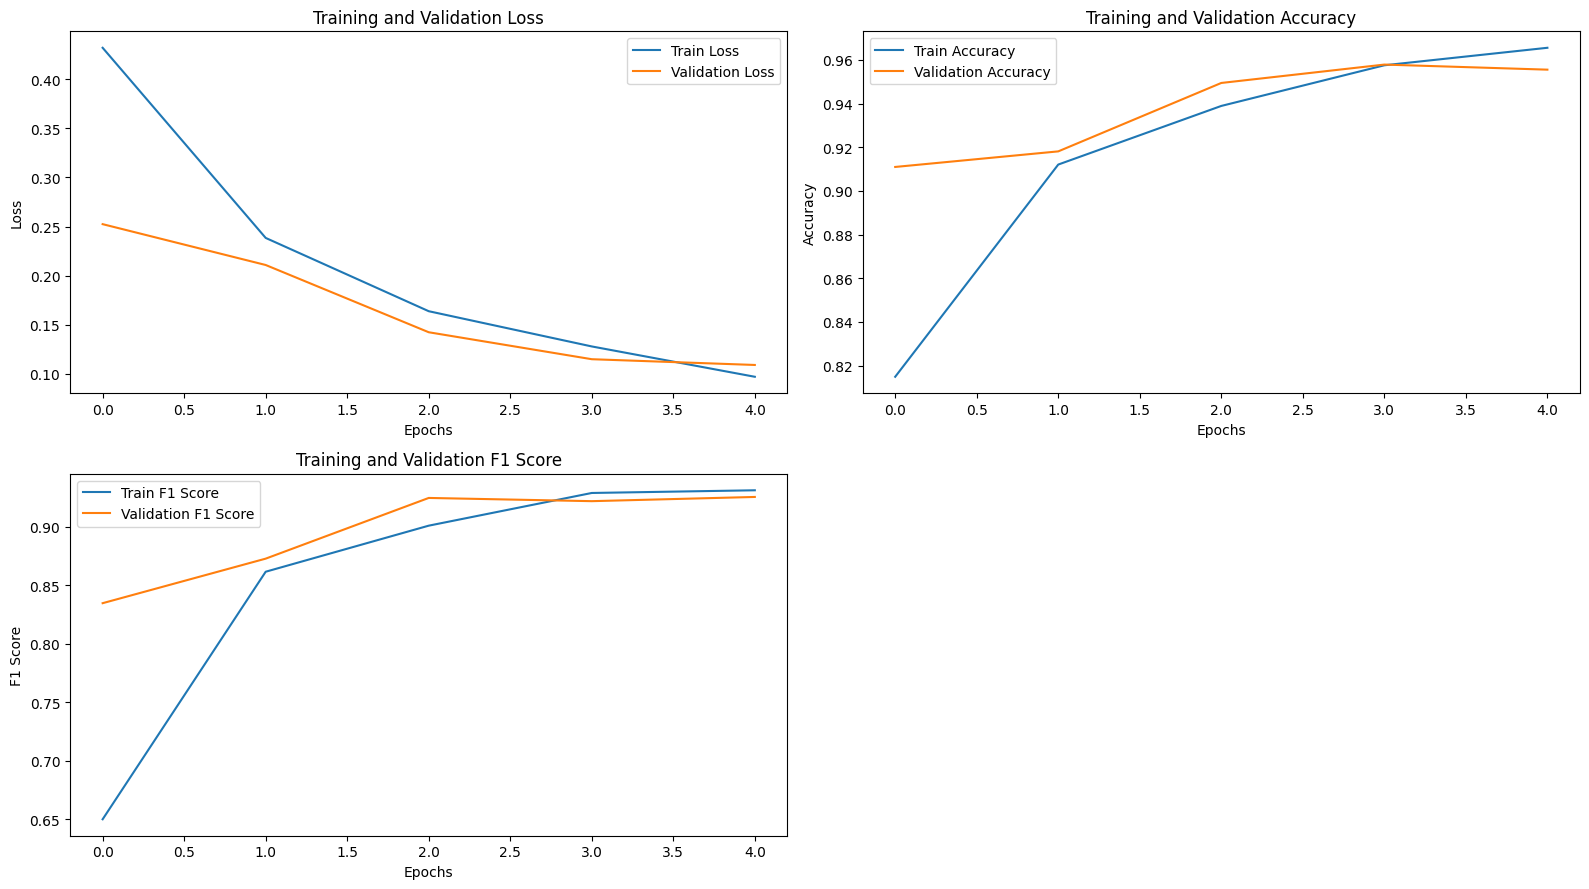

In [192]:
plot_training_history(train_loss_history, train_acc_history, train_f1_history,
                      valid_loss_history, valid_acc_history, valid_f1_history)